In [1]:
from pypetri.elements import *
from pypetri.petri_net import *
from pypetri.example_nets import *
import math

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random

from tqdm import tqdm
from rltk import rl_utils

In [2]:
class ReplayBuffer():
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        # return np.array(state), action, reward, np.array(next_state), done
        return state, action, reward, next_state, done
    
    def size(self):
        return len(self.buffer)
        

In [3]:
class P2P(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu):
        super(P2P, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.f = f
        self.adj_pt = adj_pt
        self.pm = torch.matmul(self.adj_pt, self.adj_pt.t())
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        x = torch.matmul(self.pm, x)
        diag = self.pm.diagonal().unsqueeze(0).unsqueeze(2)
        x = x / diag
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
    
class T2T(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu):
        super(T2T, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.f = f
        self.adj_pt = adj_pt
        self.pm = torch.matmul(self.adj_pt.t(), self.adj_pt)
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        x = torch.matmul(self.pm, x)
        
        diag = self.pm.diagonal()+1
        diag = diag.unsqueeze(0).unsqueeze(2)
        x = x / diag
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
    
class T2P(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu, add_bias=True):
        super(T2P, self).__init__()
        self.adj_pt = adj_pt
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.add_bias = add_bias
        self.batch_norm = nn.BatchNorm1d(dim_out)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
    def forward(self, x):
        x = torch.matmul(self.adj_pt, x)
        x = torch.matmul(x, self.weight.t())
        if self.add_bias:
            x = x + self.bias.unsqueeze(0)
            
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
            
        x = self.f(x)
        return x
        
class P2T(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu, add_bias=True):
        super(P2T, self).__init__()
        self.adj_pt = adj_pt
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.add_bias = add_bias
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, x):
        x = torch.matmul(self.adj_pt.t(), x)
        x = torch.matmul(x, self.weight.t())
        if self.add_bias:
            x = x + self.bias.unsqueeze(0)
            
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
        

In [4]:
class GCPN_layer(torch.nn.Module):
    def __init__(self, lp_in, lt_in, lp_out, lt_out, adj_matrix):
        super(GCPN_layer, self).__init__()
        self.P2P = P2P(lp_in, lp_out, adj_matrix)
        self.T2T = T2T(lt_in, lt_out, adj_matrix)
        self.P2T = P2T(lp_out, lt_out, adj_matrix)
        self.T2P = T2P(lt_out, lp_out, adj_matrix)
        
    def forward(self, p, t):
        p1 = self.P2P(p)
        t1 = self.T2T(t)
        
        dt = self.P2T(p1)
        t2 = t1 + dt
        
        dp = self.T2P(t2)
        p2 = p1 + dp
        
        return p2, t2

In [5]:
class SV_layer(torch.nn.Module):
    def __init__(self, lp_in, lt_in, adj_matrix):
        super(SV_layer, self).__init__()
        self.p_dim = adj_matrix.shape[0]
        self.T2P = T2P(lt_in, lp_in, adj_matrix)
        self.fc = nn.Linear(self.p_dim * lp_in, 1)
        
    def forward(self, p, t):
        dp = self.T2P(t)
        p1 = p+dp
        
        batch_size = p1.size(0)
        
        p1 = p1.view(batch_size, -1)
        out = self.fc(p1)
        return out
        

In [6]:
class AC_layer(torch.nn.Module):
    def __init__(self, lp_in, lt_in, adj_matrix):
        super(AC_layer, self).__init__()
        self.t_dim = adj_matrix.shape[1]
        self.lt_in = lt_in
        self.P2T = P2T(lp_in, lt_in, adj_matrix)
        self.fc = nn.Linear(self.t_dim * lt_in, self.t_dim)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, p, t):
        dt = self.P2T(p)
        t1 = t+dt
        
        batch_size = t1.size(0)
        
        t1 = t1.view(batch_size, self.t_dim * self.lt_in)
        out = self.fc(t1)
        out = F.softmax(out, dim=-1)
        # out = self.softmax(t1)
        # print(p, out)
        return out

In [7]:

class GPNPolicyNet(torch.nn.Module):
    def __init__(self, lp0, lt0, adj_matrix, device):
        super(GPNPolicyNet, self).__init__()
        self.adj_matrix = torch.from_numpy(adj_matrix).float().to(device)
        
        self.gcpn_1 = GCPN_layer(lp0, lt0, 8, 8, self.adj_matrix)
        self.gcpn_2 = GCPN_layer(8, 8, 16, 16, self.adj_matrix)
        self.gcpn_3 = GCPN_layer(16, 16, 64, 64, self.adj_matrix)
        self.gcpn_4 = GCPN_layer(64, 64, 16, 16, self.adj_matrix)
        self.ac = AC_layer(16, 16, self.adj_matrix)
        

    def forward(self, p, t):
        if isinstance(p, np.ndarray):
            p = torch.from_numpy(p).float()
        if isinstance(t, np.ndarray):
            t = torch.from_numpy(t).float()
        p1, t1 = self.gcpn_1(p, t)
        p2, t2 = self.gcpn_2(p1, t1)
        p3, t3 = self.gcpn_3(p2, t2)
        p4, t4 = self.gcpn_4(p3, t3)
        tf = self.ac(p4, t4)
        # print(tf)
        
        return tf
        

In [8]:
class GPNCriticNet(torch.nn.Module):
    def __init__(self, lp0, lt0, adj_matrix, device):
        super(GPNCriticNet, self).__init__()
        self.adj_matrix = torch.from_numpy(adj_matrix).float().to(device)
        
        self.gcpn_1 = GCPN_layer(lp0, lt0, 8, 8, self.adj_matrix)
        self.gcpn_2 = GCPN_layer(8, 8, 16, 16, self.adj_matrix)
        self.gcpn_3 = GCPN_layer(16, 16, 64, 64, self.adj_matrix)
        self.sv = SV_layer(64, 64, self.adj_matrix)
        

    def forward(self, p, t):
        if isinstance(p, np.ndarray):
            p = torch.from_numpy(p).float()
        if isinstance(t, np.ndarray):
            t = torch.from_numpy(t).float()
        p1, t1 = self.gcpn_1(p, t)
        p2, t2 = self.gcpn_2(p1, t1)
        p3, t3 = self.gcpn_3(p2, t2)
        out = self.sv(p3, t3)
        # print(out)
        return out

In [9]:

class PPO:
    def __init__(self, lp, lt, action_dim, adj_matrix, actor_lr, critic_lr, lmbda, epochs, epsilon, eps, gamma, device):
        self.action_dim = action_dim
        self.adj_matrix = torch.from_numpy(adj_matrix).float().to(device)
        self.actor = GPNPolicyNet(lp, lt, adj_matrix, device).to(device)
        self.critic = GPNCriticNet(lp, lt, adj_matrix, device).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.epsilon = epsilon
        self.eps = eps      # PPO-Clip epsilon
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            if self.epsilon > 0.01:
                self.epsilon *= 0.99
            action = np.random.randint(0, self.action_dim)
            return action
        else:
            state_p = state[0]
            state_l = state[1]
            state_p = torch.tensor([state_p], dtype=torch.float).to(self.device)
            state_l = torch.tensor([state_l], dtype=torch.float).to(self.device)

            probs = self.actor(state_p, state_l)
            noise = torch.ones_like(probs) - torch.randn_like(probs) * 0.1
            probs *= noise
            sums= probs.sum(dim=1, keepdim=True)
            probs = torch.div(probs, sums)
            action_list = torch.distributions.Categorical(probs)

            action = action_list.sample()
            return action.item()

    def update(self, transition_dict):
        # states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        p_states = [item[0] for item in transition_dict['states']]
        t_states = [item[1] for item in transition_dict['states']]
        
        p_states = torch.tensor(p_states, dtype=torch.float).squeeze(0).to(self.device)
        t_states = torch.tensor(t_states, dtype=torch.float).squeeze(0).to(self.device)
        
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        # next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        next_p_states = [item[0] for item in transition_dict['next_states']]
        next_t_states = [item[1] for item in transition_dict['next_states']]
        
        next_p_states = torch.tensor(p_states, dtype=torch.float).squeeze(0).to(self.device)
        next_t_states = torch.tensor(t_states, dtype=torch.float).squeeze(0).to(self.device)
        
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_p_states, next_t_states) * (1-dones)
        td_delta = td_target - self.critic(p_states, t_states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(p_states, t_states).gather(1, actions) + 1e-10).detach()
        
        
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(p_states, t_states).gather(1, actions) + 1e-10)
            
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps)
            
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            # print(self.actor(p_states, t_states), actor_loss)
            critic_loss = torch.mean(F.mse_loss(self.critic(p_states, t_states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            # torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0) 
            critic_loss.backward()
            
            
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            # for name, param in self.actor.named_parameters():
            #     if param.grad is not None:
            #         print(f'Parameter: {name}, Gradient norm: {torch.norm(param.grad)}')


In [10]:
actor_lr = 1e-3
critic_lr = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.99
lmbda = 0.95
epochs = 10
epsilon = 0.1   # greedy
eps = 0.1

efm_net = EmptyNet('efm_net')
initial_file_path = 'initial_file/neural_petri_net.csv'
efm_net.init_by_csv(initial_file_path)
efm_net.set_dt(1)

lp = efm_net.get_state()[0].shape[1]
lt = efm_net.get_state()[1].shape[1]
action_dim = efm_net.get_action_space()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
agent = PPO(lp, lt, action_dim, efm_net.get_adj_matrix(), actor_lr, critic_lr, lmbda, epochs, epsilon, eps, gamma, device)

cuda


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_1403714/2742132578.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state_p = torch.tensor([state_p], dtype=torch.float).to(self.device)
/tmp/ipykernel_1403714/2742132578.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_p_states = torch.tensor(p_states, dtype=torch.float).squeeze(0).to(self.device)
/tmp/ipykernel_1403714/2742132578.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_t_states = torch.tensor(t_states, dtype=torch.float).squeeze(0

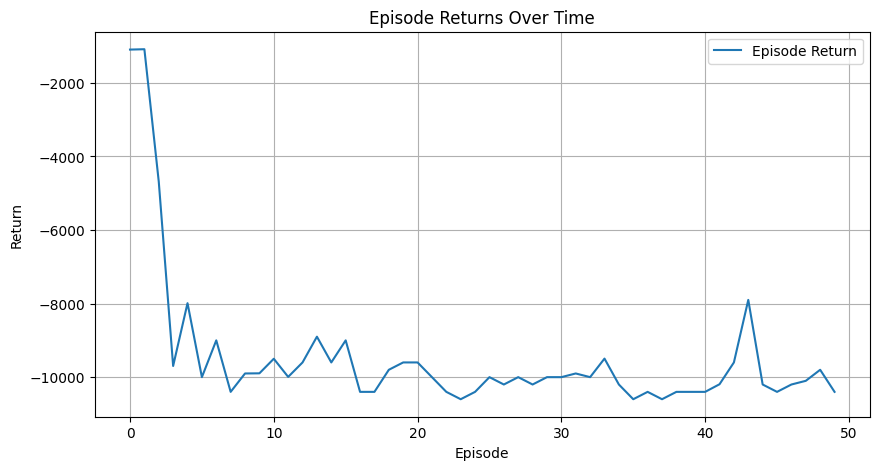

Iteration 1: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s, episode=100, return=-10331.100]


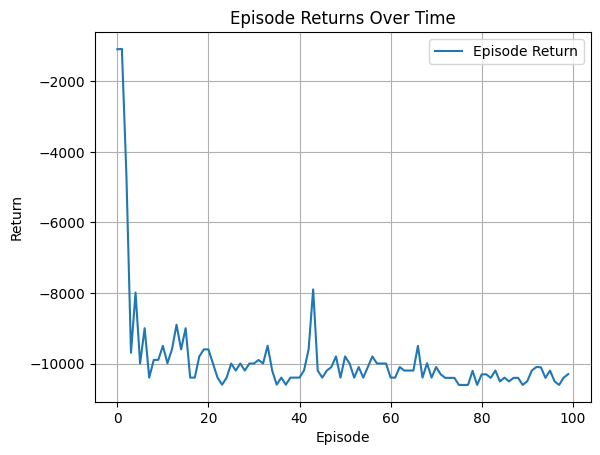

In [11]:
plt.figure(figsize=(10, 5))
plt.title('Episode Returns Over Time')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid(True)

return_list = []
action_list = []
for i in range(2):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = efm_net.reset()
            done = False
            this_action = []
            
            ## sample one sequence
            while not done:
                action = agent.take_action(state)
                this_action.append(action)
                next_state, reward, done = efm_net.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state  
                episode_return += reward

                if efm_net.train_time > 100:
                    done = True
            
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                    'return': '%.3f' % np.mean(return_list[-10:])})
                action_list.append(this_action)
            pbar.update(1)
    
    plt.cla()
    plt.plot(return_list, label='Episode Return')
    plt.title('Episode Returns Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()
    plt.pause(0.1)        
    
    if (i+1) % 10 == 0:
        torch.save(agent.q_net.state_dict(), 'model/GCPN_5Layer_L_PPO.pth')

In [12]:
state = efm_net.reset()
action = agent.take_action(state)
print(action)

34


In [13]:
state, reward, done, reward_dict = efm_net.step(action, debug=True)
action = agent.take_action(state)
print(efm_net.last_fire)
print(action, reward_dict, done)

34 {'unready_fire': -5, 'progress': np.float64(0.0)} False


In [14]:
# total_params = sum(p.numel() for p in agent.actor.gcpn_3.P2T.parameters())

# print(f"Total parameters: {total_params}")